In [598]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [599]:
df = pd.read_csv('./csv/data/_fixed_train_data.csv')
df = df.drop(['screen_height', 'screen_width'], axis=1)

In [600]:
df_test = pd.read_csv('./csv/data/_test_data.csv')
df_test = df_test.drop(['screen_height', 'screen_width'], axis=1)

In [601]:
df.shape

(50, 6)

In [602]:
df.head()

,left_iris_x,left_iris_y,right_iris_x,right_iris_y,point_x,point_y
0,918.132019,237.674667,789.455261,224.463196,50,50
1,928.395813,239.883713,799.210266,226.113571,50,50
2,925.597412,243.061539,796.765564,230.003876,50,50
3,922.151428,244.250381,794.155334,231.922043,50,50
4,920.940125,245.343353,792.663208,233.486832,50,50


In [603]:
df.describe()

,left_iris_x,left_iris_y,right_iris_x,right_iris_y,point_x,point_y
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,739.517222,299.272761,617.482393,297.284404,720.000000,395.000000
std,161.782044,43.881637,162.439251,45.482796,605.350295,311.710227
min,512.911316,232.306213,399.130829,224.463196,50.000000,50.000000
25%,577.322845,248.445267,445.045639,254.812714,50.000000,50.000000
50%,722.431305,325.465530,597.999939,322.933838,720.000000,395.000000
75%,904.209549,337.024307,786.737473,328.206551,1390.000000,740.000000
max,928.395813,343.275635,799.210266,349.051758,1390.000000,740.000000


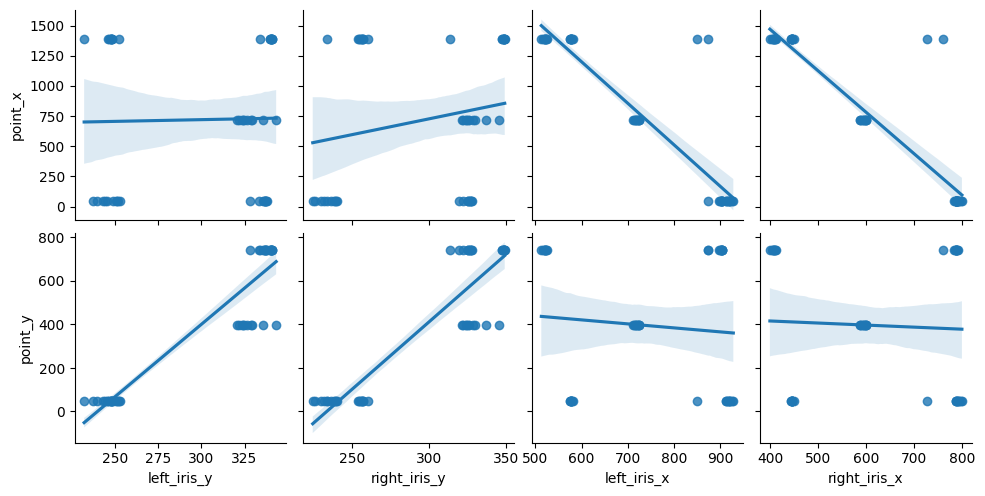

In [604]:
sns.pairplot(df, x_vars=['left_iris_y', 'right_iris_y', 'left_iris_x',
             'right_iris_x'], y_vars=['point_x', 'point_y'], kind='reg')
plt.show()

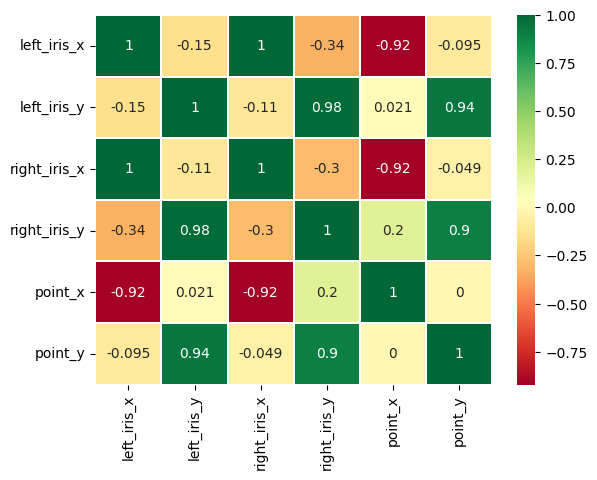

In [605]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
plt.show()

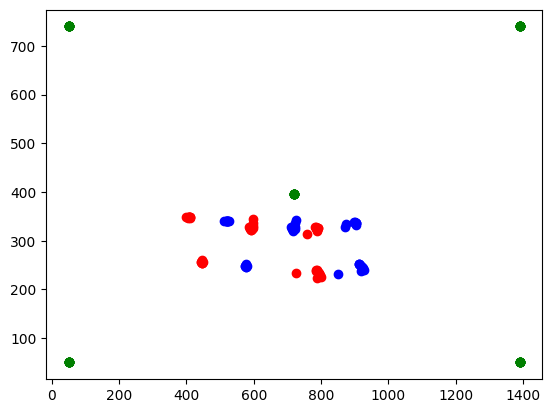

In [606]:
#plot eyes point
plt.scatter(df['left_iris_x'], df['left_iris_y'], color='blue')
plt.scatter(df['right_iris_x'], df['right_iris_y'], color='red')
plt.scatter(df['point_x'], df['point_y'], color='green')
plt.show()

In [607]:
X_train_x = df[['left_iris_x', 'right_iris_x']]
y_train_x = df['point_x']

In [608]:
sc = StandardScaler()
X_train_x = sc.fit_transform(X_train_x)

In [609]:
X_train_x[:5]

array([[1.11525474, 1.06943875],
       [1.17934095, 1.1301017 ],
       [1.16186798, 1.11489895],
       [1.14035157, 1.09866685],
       [1.1327883 , 1.08938784]])

In [610]:
X_test_x = df_test[['left_iris_x', 'right_iris_x']]
y_test_x = df_test['point_x']

In [611]:
sc = StandardScaler()
X_test_x = sc.fit_transform(X_test_x)

In [612]:
model_x = linear_model.LinearRegression()
model_x.fit(X_train_x, y_train_x)
y_pred_x = model_x.predict(X_test_x)
r2_score(y_test_x, y_pred_x)

0.9716414558923362

In [613]:
y_pred_x

array([ 310.15954614,   80.06824302,   24.43302778,   52.14862454,
         48.0434024 ,   37.19926274,   45.14750043,   55.62809602,
         61.01329037,   68.34434457, 1094.18897061, 1335.59476447,
       1342.72506682, 1357.31199935, 1373.04678399, 1369.18765736,
       1352.9237426 , 1328.07831697, 1314.10910262, 1304.29174001,
        777.43032874,  798.29320793,  820.57926669,  820.20736893,
        796.75533128,  802.40173468,  798.29346305,  808.95831279,
        824.65913887,  820.1368865 ,   59.7557678 ,  111.95656778,
        108.73099465,   87.2565231 ,  103.9860568 ,   99.37721033,
         96.16712755,  100.5170495 ,   84.49336354,  107.2033952 ,
        939.32536849, 1332.56056979, 1344.85192378, 1343.35610174,
       1323.56126714, 1315.55708342, 1336.98910002, 1359.54525687,
       1360.40420932, 1363.0465409 ])

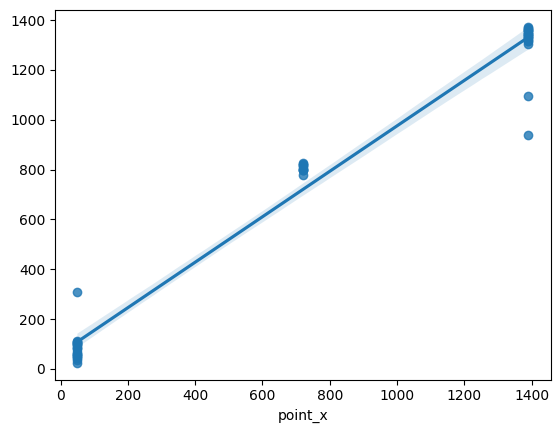

In [614]:
sns.regplot(x=y_test_x, y=y_pred_x)
plt.show()

In [615]:
X_train_y = df[['left_iris_y', 'right_iris_y']]
y_train_y = df['point_y']

In [616]:
sc = StandardScaler()
X_train_y = sc.fit_transform(X_train_y)

In [617]:
X_train_y[:5]

array([[-1.41798428, -1.61732643],
       [-1.36713219, -1.58067233],
       [-1.29397884, -1.49427041],
       [-1.26661175, -1.45166878],
       [-1.24145161, -1.41691552]])

In [618]:
X_test_y = df_test[['left_iris_y', 'right_iris_y']]
y_test_y = df_test['point_y']

In [619]:
sc = StandardScaler()
X_test_y = sc.fit_transform(X_test_y)

In [620]:
model = linear_model.LinearRegression()
model.fit(X_train_y, y_train_y)
y_pred_y = model.predict(X_test_y)
r2_score(y_test_y, y_pred_y)

0.1510971776368406

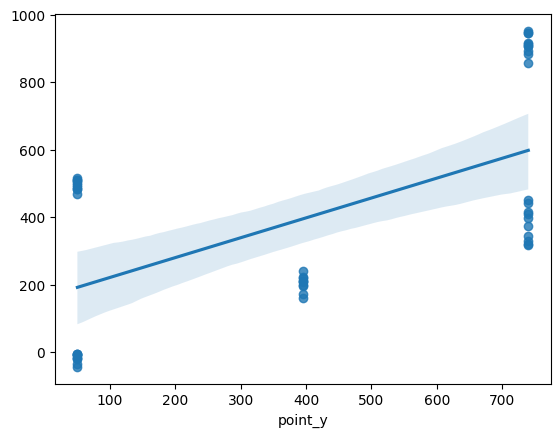

In [621]:
sns.regplot(x=y_test_y, y=y_pred_y)
plt.show()

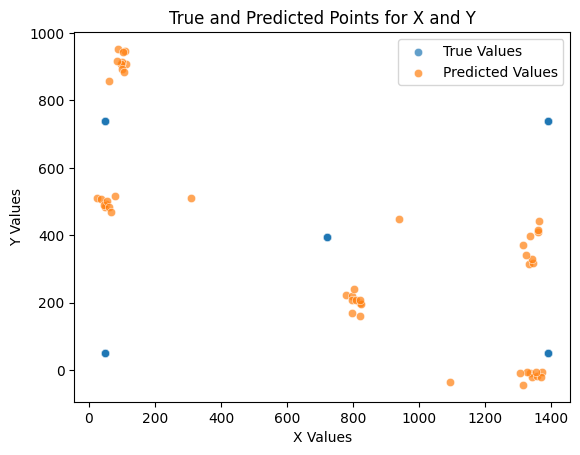

In [622]:
data = {'True X': y_test_x, 'Predicted X': y_pred_x,
        'True Y': y_test_y, 'Predicted Y': y_pred_y}

sns.scatterplot(x='True X', y='True Y', data=data,
                label='True Values', alpha=0.7)
sns.scatterplot(x='Predicted X', y='Predicted Y', data=data,
                label='Predicted Values', alpha=0.7)

plt.title('True and Predicted Points for X and Y')
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.legend()

plt.show()

In [623]:
df_data = pd.DataFrame(data)
df_data['True XY'] = list(zip(df_data['True X'], df_data['True Y']))

In [624]:
df_data.head()

,True X,Predicted X,True Y,Predicted Y,True XY
0,50,310.159546,50,510.994962,"(50, 50)"
1,50,80.068243,50,516.301248,"(50, 50)"
2,50,24.433028,50,510.015673,"(50, 50)"
3,50,52.148625,50,494.116064,"(50, 50)"
4,50,48.043402,50,482.759082,"(50, 50)"


In [625]:
# Precision is calculated via the Root Mean Square from the
# successive data points [in degrees of visual angle θi between
# successive (x1,y1) to (xi+1, yi+1) samples], both for each eye
# individually and as a mean from the two

# Another option to describe the variation in the data is to
# measure the standard deviation of the data set, equivalent
# to the RMS normalized by the mean

def func_x(group): return np.sqrt(
    np.sum(np.square([group['Predicted X'], group['True X']])))


def func_y(group): return np.sqrt(
    np.sum(np.square([group['Predicted Y'], group['True Y']])))


precision_x = df_data.groupby('True XY').apply(func_x)
precision_y = df_data.groupby('True XY').apply(func_y)

precision_xy = (precision_x + precision_y) / 2
precision_xy = precision_xy / np.mean(precision_xy)
print('mean', precision_xy)

mean True XY
(50, 50)       0.381311
(50, 740)      0.788431
(720, 395)     0.937160
(1390, 50)     1.210025
(1390, 740)    1.683074
dtype: float64


In [647]:
precision_xy[(50,50)]

0.38131050706728997

In [648]:
data = {}

for index, row in df_data.iterrows():

    outer_key = str(row['True X'])
    inner_key = str(row['True Y'])

    if outer_key not in data:
        data[outer_key] = {}

    data[outer_key][inner_key] = {
        'predicted_x': df_data[(df_data['True X'] == row['True X']) & (df_data['True Y'] == row['True Y'])]['Predicted X'].values.tolist(),
        'predicted_y': df_data[(df_data['True X'] == row['True X']) & (df_data['True Y'] == row['True Y'])]['Predicted Y'].values.tolist(),
        'PrecisionSD': precision_xy[(row['True X'], row['True Y'])]
    }

In [649]:
data

{'50': {'50': {'predicted_x': [310.1595461416455,
    80.06824302134419,
    24.433027782905583,
    52.14862454262834,
    48.04340240468355,
    37.19926274128693,
    45.14750043317258,
    55.62809601914523,
    61.013290366833985,
    68.34434457075918],
   'predicted_y': [510.9949617146765,
    516.3012481462806,
    510.01567274949355,
    494.1160639164855,
    482.75908159484436,
    508.05188944435486,
    490.0979841810887,
    500.57375245798227,
    484.7483552376151,
    468.8329789080469],
   'PrecisionSD': 0.38131050706728997},
  '740': {'predicted_x': [59.75576780208951,
    111.95656777852537,
    108.73099465009113,
    87.25652309894394,
    103.98605680445053,
    99.37721033444927,
    96.16712754758532,
    100.51704950025544,
    84.49336353660465,
    107.20339520353627],
   'predicted_y': [858.1704835123357,
    906.6087422433509,
    945.3302464011042,
    952.5695107542626,
    944.8962983662391,
    914.6588819086896,
    908.4290734442561,
    891.97408064

In [ ]:
data = np.array([y_pred_x, y_pred_y]).T

In [ ]:
data.shape

(50, 2)

In [ ]:
model = KMeans(n_clusters=5, n_init='auto', init='k-means++')
y_kmeans = model.fit_predict(data)

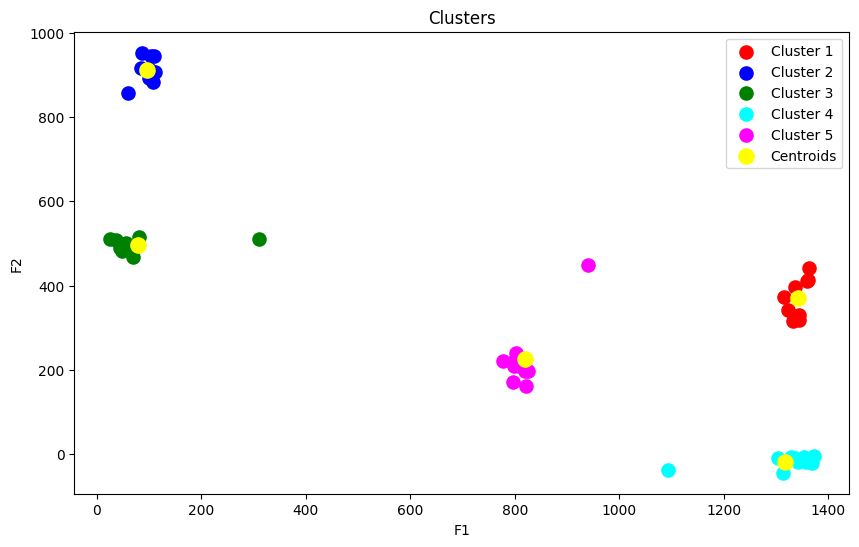

In [ ]:
plt.figure(figsize=(10, 6))

plt.scatter(data[y_kmeans == 0, 0], data[y_kmeans == 0, 1],
            s=90, c='red', label='Cluster 1')
plt.scatter(data[y_kmeans == 1, 0], data[y_kmeans == 1, 1],
            s=90, c='blue', label='Cluster 2')
plt.scatter(data[y_kmeans == 2, 0], data[y_kmeans == 2, 1],
            s=90, c='green', label='Cluster 3')
plt.scatter(data[y_kmeans == 3, 0], data[y_kmeans == 3, 1],
            s=90, c='cyan', label='Cluster 4')
plt.scatter(data[y_kmeans == 4, 0], data[y_kmeans == 4, 1],
            s=90, c='magenta', label='Cluster 5')
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[
            :, 1], s=120, c='yellow', label='Centroids')

plt.title('Clusters')

plt.xlabel('F1')
plt.ylabel('F2')

plt.legend()

plt.show()

### -------- teste --------

In [ ]:
def plot(ax, y_test_x, y_pred_x, y_test_y, y_pred_y, title=None):

    y_test_x = np.array(y_test_x)
    y_test_y = np.array(y_test_y)

    true_points = [(y_test_x[i], y_test_y[i]) for i in range(len(y_test_x))]

    error_range = 0.05

    data = {'True X': y_test_x, 'Predicted X': y_pred_x,
            'True Y': y_test_y, 'Predicted Y': y_pred_y}

    sns.scatterplot(x='True X', y='True Y', data=data,
                    label='True Values', alpha=0.7, ax=ax, color='red')
    sns.scatterplot(x='Predicted X', y='Predicted Y', data=data,
                    label='Predicted Values', alpha=0.7, ax=ax, color='green')

    circle_radius = error_range * (max(y_test_x) - min(y_test_x)
                                   + max(y_test_y) - min(y_test_y)) / 2

    for true_x, true_y in true_points:

        x_within_range = [y_pred_x[j] for j in range(len(y_test_x)) if abs(
            y_test_x[j] - true_x) <= error_range]
        y_within_range = [y_pred_y[j] for j in range(len(y_test_y)) if abs(
            y_test_y[j] - true_y) <= error_range]

        if len(x_within_range) > 1 and len(y_within_range) > 1:

            combined_predictions = x_within_range + y_within_range
            combined_true = [true_x] * len(x_within_range) + \
                [true_y] * len(y_within_range)
            #true_values = [true_x] * len(x_within_range) + \
            #    [true_y] * len(y_within_range)

            r2_combined = r2_score(combined_true, combined_predictions)
            mae_combined = mean_absolute_error(
                combined_true, combined_predictions)

            circle = plt.Circle((true_x, true_y), circle_radius,
                                color='yellow', fill=False)
            ax.add_patch(circle)

            ax.text(true_x + 0.1, true_y + 0.1, f'R2={r2_combined:.2f}\nMAE={mae_combined:.2f}',
                    fontsize=8, color='blue')

    title = title if title else 'True and Predicted Points for X and Y'
    ax.set_title(title)
    ax.legend()

In [ ]:
def analysis(df, ax=None, title=None):

    # x
    X_x = df[['left_iris_x', 'right_iris_x']]
    X_y = df['point_x']

    sc = StandardScaler()
    X_x = sc.fit_transform(X_x)

    X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(
        X_x, X_y, test_size=0.2, random_state=42)

    model = linear_model.LinearRegression()
    model.fit(X_train_x, y_train_x)
    y_pred_x = model.predict(X_test_x)
    r2_score(y_test_x, y_pred_x)

    # y
    X_y = df[['left_iris_y', 'right_iris_y']]
    y_y = df['point_y']

    sc = StandardScaler()
    X_y = sc.fit_transform(X_y)

    X_train_y, X_test_y, y_train_y, y_test_y = train_test_split(
        X_y, y_y, test_size=0.2, random_state=42)

    model = linear_model.LinearRegression()
    model.fit(X_train_y, y_train_y)
    y_pred_y = model.predict(X_test_y)
    r2_score(y_test_y, y_pred_y)

    plot(ax, y_test_x, y_pred_x, y_test_y, y_pred_y, title)

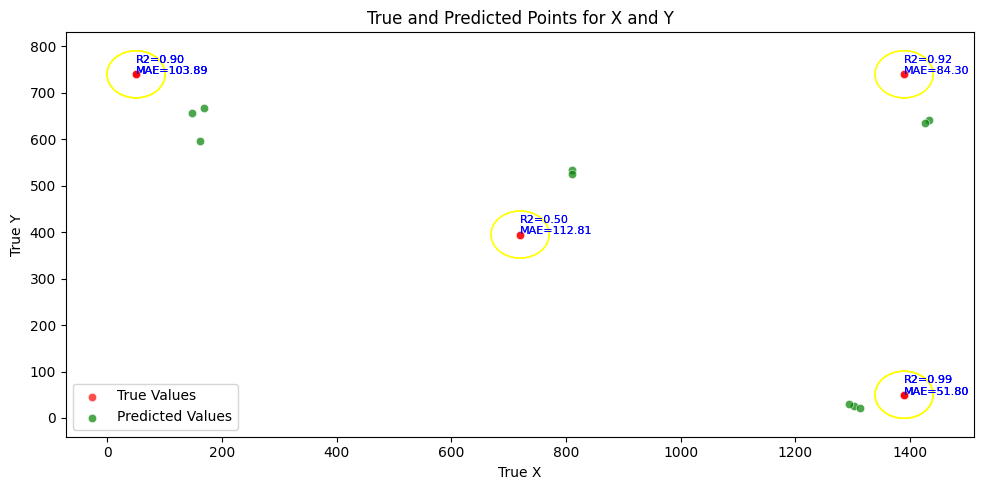

In [ ]:
df = pd.read_csv('./csv/data/_fixed_train_data.csv')
df = df.drop(['screen_height', 'screen_width'], axis=1)

df_list = [df]

# num_rows = len(df_list) // 2 + len(df_list) % 2
# num_cols = min(2, len(df_list))

num_rows = len(df_list)
num_cols = 1

fig_height = 5 * num_rows
fig, axes = plt.subplots(
    num_rows, num_cols, figsize=(10, fig_height), squeeze=False)

for i, df in enumerate(df_list):

    # row_idx = i // num_cols
    # col_idx = i % num_cols

    row_idx = i
    col_idx = 0

    ax = axes[row_idx, col_idx]
    analysis(df, ax)

plt.tight_layout()
plt.show()